In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.sparse import diags
np.set_printoptions(precision=2)
from simple_plot import *

# Ch. 5 - Basic Optimization

As engineers, we try to find ways to make things work and, when we can, we try to find the __best__ way to make things work. 

How do you determine what is "best"? 

Typical approach:

- Identify __control variables__: parameters you can tune:
$$ \boldsymbol{x} = {x_0,x_1,x_2,\ldots,x_{n-1}} $$


- Choose an __objective function__: function of control variables that measures the scalar "quality" or "cost" of a design: $$f(\boldsymbol{r}) : \mathbb{R}^n \rightarrow \mathbb{R}$$

- Identify __constraints__ (relationships that must be satisfied by control variables)
and the __feasible set__ (allowed choices of control variables that satisfy the constraints)

    - Equality constraints: $$g_j(\boldsymbol{x}) = 0$$
    
    - Inequality constraints: $$g_k(\boldsymbol{x}) \leq 0$$

- Find the combination of control variable values that gives the maximum quality or minimum cost:<br/><br/>
$f(\boldsymbol{x_0})$ has a minimum at $\boldsymbol{x_0}$ in region $R$

$$f(\boldsymbol{x}) \geq f(\boldsymbol{x_0}) \qquad \forall \boldsymbol{x} \in R $$  
<br/>
Note: maximizing $f$ $\equiv$ minimizing $-f$ and we can choose either sign
<br><br>
Typically choose sign leading to _minimization_

__Note:__ We are also motivated by physics laws that are formulated as minimum principles:

- Stable equilibrium corresponds to minimum energy

- Soap bubbles minimize surface area

- Hamilton's principle formulates dynamics as minimizing a time integral involving energy

- Snell's law describes refraction in terms of minimum travel time


Initial __classification of optimization problems__:

- __Unconstrained vs. Constrained__

- __Derivative-free vs. derivative methods__

We will start simple with unconstrained, derivative-free optimization with a single control variable and work up from there...



## Section 5.1 - Unconstrained Optimization 
## (Derivative-Free Methods)

If you think back to calculus class, optimization may seem quite straightforward:

- Compute the derivative $f'(x) = \frac{df}{dx}$.

- Solve $f'(x_0) = 0$ to find extrema. 

- Check the sign of the second derivative to distinguish maxima, minima, and inflection points: $$f''(x_0) > 0 \implies \text{ min}$$

> Note: $f'(x_0) = 0 \text{ and } f''(x_0) \geq 0$ are _necessary_ conditions for a minimum.<br><br>
$f'(x_0) = 0 \text{ and } f''(x_0) > 0$ are _sufficient_ conditions for a _local_ minimum. The inequality rules out saddle points and behavior determined by higher order terms.
<br><br>
Global minimum is not ensured by local conditions; need to compare values at relative minima.

When optimizing with multiple control variables, the vector of first derivatives of the objective functions must vanish, so the first derivative condition changes:
$$f'(x) = 0 \rightarrow \nabla f(\boldsymbol{x}) = \frac{\partial f}{\partial x_i}=0$$

Here we have dropped the subscript 0 for simplicity, but remember that these conditions are evaluated at the candidate minimum point.

With multiple variables, the second derivative condition involves how each component of the gradient changes with respect to each control variable:
<br>$f''(x) > 0 \rightarrow$ the Hessian, $H(\boldsymbol{x}) = \big[ \frac{\partial^2 f}{\partial x_i \partial x_j} \big]$, is positive (semi-)definite.

Where does that result come from? Once again, our friend Brook Taylor helps us out. Call the local minimum $x^*$ and consider points nearby given by $x = x^* + \alpha d$. The values at those nearby points can be expressed by expanding the objective function in a Taylor series about $x^*$:

$$f(x) = f(x^*) + \alpha \nabla f(x^*)^T d + \frac{\alpha^2}{2} d^T H(x^*) d + O(\alpha^3)$$

Applying the first condition criterion, $\nabla f$ vanishes, so the _second order necessary condition_ is: $$ d^T H(x^*) d \geq 0 \; \forall \; d$$

In other words, the Hessian must be positive semi-definite. If the Hessian is positive definite, that is _sufficient_ to ensure a local minimum at $x^*$.

The basic idea of just checking the derivatives sounds good, but some steps may not be practical. In particular, evaluating the derivative may not be feasible:

- Analytic expression not available

- Prohibitively expensive to compute

So consider a __derivative-free__ approach to optimization where we evaluate the function at desired points, but we do NOT evaluate the derivative. Similar to basic root-finding methods, we assume that an interval is given in which to find the minimum.

### Golden section search

Golden section search assumes that the function is continuous and _unimodal_ (having a single relative minimum and _monotonic_ on either side of the minimum). The task is to systematically shrink the interval where that single minimum must reside by computing only values of the function without computing derivatives.

The basic approach is to compute the values at the 2 endpoints of the starting interval and at 2 internal points. Let's number the points increasing order $x_0, x_1, x_2, x_3$ with corresponding function values $f_0, f_1, f_2, f_3$.

Comparing the magnitudes of $f_1$ and $f_2$ allows us to exclude a portion of the interval on the basis of unimodality. How exactly shoould that be done?

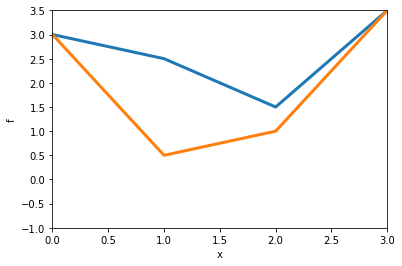

In [229]:
indexplot(np.array([0,1,2,3]),np.array([[3,2.5,1.5,3.5],[3,.5,1,3.5]]).T, labels=['x','f'])

Based on the values illustrated above, which portion of the interval should be excluded for the blue plot? For the orange plot?

Once we know how to exclude portions of the interval, we can adjust one of the interval bounds, compute at 2 new internal points,and continue refining.

Can you think of a way to do this without computing function value at 2 new internal points?

How about keeping the previously computed internal point and just computing at 1 new point?

Let's proceed to the next step with the blue data.

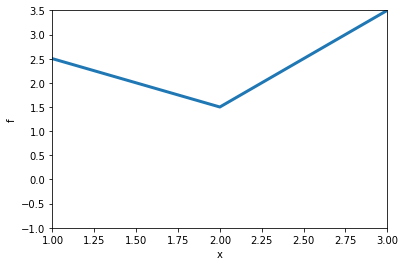

In [230]:
indexplot(np.array([1,2,3]),np.array([[2.5,1.5,3.5]]).T, labels=['x','f'])

Where should we put the new internal evaluation point? Will that decision affect how much of the remaining interval we may get to exclude? Say we choose to evaluate at 2.5; then 2 possible cases arise:

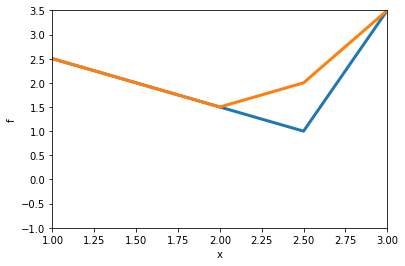

In [231]:
indexplot(np.array([1,2,2.5,3]),np.array([[2.5,1.5,1.0,3.5],[2.5,1.5,2.0,3.5]]).T, labels=['x','f'])

If the new internal function value is less than the previous (blue line), then we get to delete half the interval; but if the new internal function value is greater than the previous (orange line), we only get to exclude one quarter of the interval.

Is there a way to only do one evaluation per step and still count on consistently reducing the interval size?

The answer is yes; we just have to locate the internal points so that one of them becomes the new interval bound and the other is in the desired location for sampling the revised interval.

If $x_2$ becomes the new right endpoint, then $x_1$ should be in position as the right internal evaluation point (and vice versa).

For the algebra to make this happen, see p. 95 in Kutz. Here let's jump to the answer:
Pick the sub-interval widths in the following ratios: $$2-\phi : 2\phi-3 : 2-\phi \text{  where  } \phi = \frac{1+\sqrt{5}}{2} \approx 1.618\ldots$$

The sample points are $0.38$ and $0.62$ of the way along the interval; trimming one end shrinks the interval by a factor of $0.62$, so the new right internal evaluation points should be at $0.62^2 = 0.38$ which (by construction since $(\phi -1 )^2 = 2-\phi$) coincides with the left internal evaluation point at the previous step. 

Since there is mirror symmetry, the approach also works when the left end of the interval is trimmed.

Here is a python version of the "goldensearch" code on p. 96 with application to the problem of finding the minimum of $f(x)= x^4+10 \, x \, sin(x^2)$ on the interval $x \in [-2,1]$.

In [405]:
f = lambda x: x**4 + 10*x*np.sin(x**2)

def goldensearch(f,x_left, x_right,tol, maxiter):
    '''
    Find minimum value of function of 1 variable within an interval
    
    Args:
        f: function to be minimized
        x_left, x_right: float interval endpoints (x_left<x_right)
        tol: float interval size for termination
        maxiter: int maximum number of iterations
        
    Returns:
        a,b: float bounds of final bounding interval
        val: float function value at center of final bounding interval
    '''
    phi = (1.+np.sqrt(5))/2 #golden ratio = (x2-a)/(b-a) = (b-x1)/(b-a)
    a = x_left
    b = x_right
    x1 = b - (b-a)/phi
    x2 = a + (b-a)/phi
    f1, f2 = f(x1), f(x2)
    for j in range(maxiter):
        if f1<f2: #move right boundary
            b = x2
            x2 = x1
            f2 = f1
            x1 = b - (b-a)/phi#phi*a+(1-phi)*b
            f1 = f(x1)
        else: #move left boundary
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + (b-a)/phi#(1-phi)*a+phi*b
            f2 = f(x2)
        if(b-a)<tol:
            break
    val = f((a+b)/2)
    return a,b,val

In [406]:
a = -2
b = 1
tol = 1e-6
maxiter = 100
xleft, xright, val = goldensearch(f,a,b,tol, maxiter)
print("The minimum value f= " +str(val) + "occurs at x = " +str(xleft))

The minimum value f= -10.088219679436966occurs at x = -1.274178049042595


### Successive Parabolic Interploation

The other approach presented for 1D derivative-free optimization involves the use of local interpolants. In the golden section search, we compared the function values at the internal points but, other than that, they were not used in computing the optimum. Here we provide a way for the function values to contribute.

- Start with an interval to search for the optimum.

- Evaluate the function at the endpoints $x_1, x_3$.

- Evaluate the function at an interior point starting with $x_2 = (x_1+x_2)/2$.

- Construct the parabola through the 3 points using Lagrange interpolation:
$$p(x) = f(x_1)\frac{(x-x_2)(x-x_3)}{(x_1-x_2)(x_1-x_3)} + f(x_2)\frac{(x-x_1)(x-x_3)}{(x_2-x_1)(x_2-x_3)} + f(x_3)\frac{(x-x_1)(x-x_2)}{(x_3-x_1)(x_3-x_2)}$$

- Compute the minimum of the parabola as a proxy for the minimum of the function:
$$x_0 = \frac{x_1+x_2}{2} - \frac{(f_2-f_1)(x_3-x_1)(x_3-x_2)}{2[(x_2-x_1)(f_3-f_2)-(f_2-f_1)(x_3-x_2)]}$$

- As before, trim the interval based on comparison of the new interior value $f(x_0)$ and the od extrior value $f(x_2)$:

$$x_0<x_2 \implies: x_1^{new} = x_1^{old},x_2^{new} = x_0, x_3^{new} = x_2^{old}$$

$$x_0>x_2 \implies: x_1^{new} = x_2^{old},x_2^{new} = x_0, x_3^{new} = x_3^{old}$$

Matlab code for successive parabolic interpolation is on p. 98, and you are encouraged to code it up in python as an exercise. Matlab also has a library function `fminbnd` described on p.99. You might want to find a python library function for 1D derivative-free optimization and test it out.

### Section 5.2 - Unconstrained Optimization (Derivative Methods)

Since you should have seen derivative methods for 1D optimization before, let's go directly to multidimensional case with $n$ control variables, but let's start with $n=2$ so we can more readily create plots to illustrate our methods.

On p. 99 an elementary (but useful) example is introduced: Find the minimum of the function $$f(x,y) = x^2 + 3 y^2$$

Here we will not avoid use of the gradient:

$$\nabla f(\boldsymbol{x}) = \frac{\partial f}{\partial x} \hat{\boldsymbol{x}} + \frac{\partial f}{\partial y} \hat{\boldsymbol{y}} = 2x \, \hat{\boldsymbol{x}} + 6y \, \hat{\boldsymbol{y}}$$

Pretending that we have an initial guess to serve as the starting point in our search for the minimum (but don't know where the minimum is actually located), how can we progressively move toward the minimum.

We can think of the level sets of the function (which typically form "rings" about the minimum in its neighborhood) and try to movetoward the minimum by progressively moving to level sets associated with smaller function values. 

Having evaluated the function at our initial location, what direction should we NOT move when we want to decrease the function value? In waht direction should we move?

The function value does not change if we move along (parallel to) the level set we start on. The function value changes (at its maximum rate) if we move parallel to the direction of the gradient.

This leads to the __method of gradient descent__ also known as the __method of steepest descent__:

- Evaluate the gradient at the starting point.

- Take a step in the direction opposite the gradient (which is the direction of increasing function values).

- Continue until we are sufficiently close to a minimum (when $\big| \nabla f \big| < tol$).

Let's code up a basic gradient descent and see how it works:

In [293]:
f = lambda x : x[0]**2 + 3*x[1]**2

gradf = lambda x : np.array([2*x[0], 6*x[1]])

def grad_descent(f, x0, step, maxsteps, tol):
    x = np.zeros([maxsteps,2])
    val = np.zeros(maxsteps)
    x[0] = x0
    val[0] = f(x[0])
    for i in range(1,maxsteps):
        x[i] = x[i-1] - step * gradf(x[i-1])
        val[i] = f(x[i])
        if np.abs(val[i]-val[i-1])<tol:
            break
    return x,val,i
        

In [367]:
x0 = np.array([3,2])
maxsteps = 50
tol = 1e-4
step = 0.1

x,val,numsteps = grad_descent(f,x0,step,maxsteps,tol)

In [368]:
print("Steps to achieve tolerance: ", numsteps)
print("Min value f = ", val[numsteps])
print("History of function values: \n", val[:numsteps+1])
print("Coordinate history:\n", x[:numsteps])

Steps to achieve tolerance:  25
Min value f =  0.00012845229234353662
History of function values: 
 [2.10e+01 7.68e+00 3.99e+00 2.41e+00 1.52e+00 9.68e-01 6.19e-01 3.96e-01
 2.53e-01 1.62e-01 1.04e-01 6.64e-02 4.25e-02 2.72e-02 1.74e-02 1.11e-02
 7.13e-03 4.56e-03 2.92e-03 1.87e-03 1.20e-03 7.66e-04 4.90e-04 3.14e-04
 2.01e-04 1.28e-04]
Coordinate history:
 [[3.00e+00 2.00e+00]
 [2.40e+00 8.00e-01]
 [1.92e+00 3.20e-01]
 [1.54e+00 1.28e-01]
 [1.23e+00 5.12e-02]
 [9.83e-01 2.05e-02]
 [7.86e-01 8.19e-03]
 [6.29e-01 3.28e-03]
 [5.03e-01 1.31e-03]
 [4.03e-01 5.24e-04]
 [3.22e-01 2.10e-04]
 [2.58e-01 8.39e-05]
 [2.06e-01 3.36e-05]
 [1.65e-01 1.34e-05]
 [1.32e-01 5.37e-06]
 [1.06e-01 2.15e-06]
 [8.44e-02 8.59e-07]
 [6.76e-02 3.44e-07]
 [5.40e-02 1.37e-07]
 [4.32e-02 5.50e-08]
 [3.46e-02 2.20e-08]
 [2.77e-02 8.80e-09]
 [2.21e-02 3.52e-09]
 [1.77e-02 1.41e-09]
 [1.42e-02 5.63e-10]]


So it looks like the gradient descent search does get close to the minimum at $(x,y) = (0,0)$, but let's plot the steps to see how things progress. (Note that we need to transpose the array to separate the coordinates for plotting.)

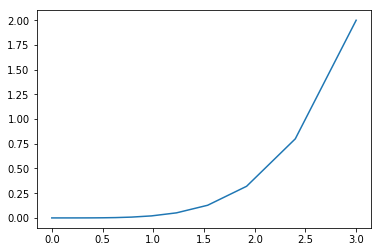

In [369]:
plt.plot(x.T[0],x.T[1])

Let's put this together with a contourplot of the objective function to check that the direction really coincides with $\nabla f$. First we compute a grid of values of $f$, then we use a modified version of `arraycontourplot` (from `simpleplot`) to plot the search points together with the contours of $f$.

In [370]:
n=25
xvals = np.linspace(-3,3,n)
yvals = np.linspace(-3,3,n)
fvals = np.zeros([n,n])
f2 = lambda x,y:x**2+3*y**2
for i in range(n):
    for j in range(n):
        fvals[j,i] =  f2(xvals[i],yvals[j])


In [371]:
def arraycontourplot(x,xvals, yvals, fvals, levels=[-1000,0], labels=['x','y'], 
    titlestring='', filled=False):
    """
    inputs:
    xvals: a 1d numpy array of values for the first coordinate
    yvals: a 1d numpy array of values for the second coordinate
    fvals: a 2d numpy array of function values on the coordinate grid
    levels: a list of contour values
    vars: a list containing the symbolic variables
    titlestring: a string specifying the plot title
    -----
    product: a contourplot based on the array of function values
    """
    fig = plt.figure()
    X,Y = np.meshgrid(yvals,xvals) #switch for more intuitive format
    if filled==True:
        cp = plt.contourf(X, Y, fvals, levels, hatches=['x','+']) #, linestyles='dashed')
    else:
        cp = plt.contour(X, Y, fvals, levels) #, linestyles='dashed')
    # plt.clabel(cp, inline=True, fontsize=10)
    plt.title(titlestring)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    #plt.axis('square')
    plt.axis('tight')
    plt.plot(x.T[0],x.T[1], marker='o', markersize=10, fillstyle='none', linewidth=2)
    plt.show()
    return cp

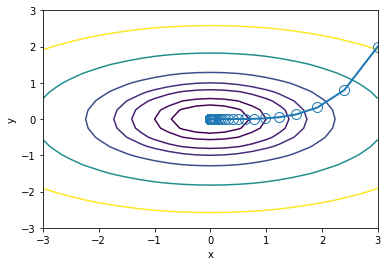

In [376]:
levels=[0,0.5,1,2,3,5,10,20]
arraycontourplot(x,xvals, yvals, fvals, levels, labels=['x','y'], 
    titlestring='', filled=False)

So the search steps do appear to follow the "fall line" (perpendicular to the level sets or isosurfaces) and eventually arrives very near the minimum at the origin.

The big question is: how big should the steps be?

Above, we just picked a small step and eventually we got close to the minimum. Can we do something more efficient?

One approach is to not take a step of a predetermined size, but instead:

- Use the starting point and gradient direction to define a line.

- Get the next point by searching to find the minimum on the line ("line search")  

- Recompute the gradient and continue...

How would that change the picture?

First let's note some special cases:

What if you start at a different location?

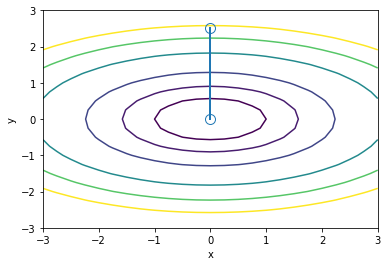

In [379]:
x =  np.array([[0,2.5],[0,0]])
arraycontourplot(x,xvals, yvals, fvals, levels=[0,1,2.5,5,10,15,20], labels=['x','y'], 
    titlestring='', filled=False)

Starting at the right place, the gradient points at the minimum, and the search consists of a single step.

Consider an alternative objective function:
$$f(x,y) = x^2+y^2$$

What happens then? What are the level sets? Where does the gradient point? How many steps does it take to find the minimum?

Things are not always so convenient, so let's return to line search for $f = x^2 + 3 y^2$:

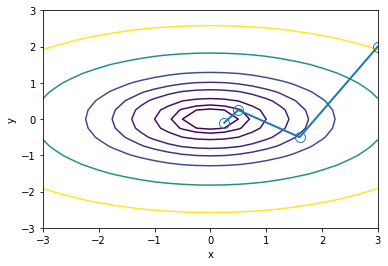

In [398]:
levels=[0,0.25,0.5,1,2,3.1,5,10,20]
x =  np.array([[3,2],[1.6,-0.5],[0.5,0.25], [0.25,-0.1]])
arraycontourplot(x,xvals, yvals, fvals, levels, labels=['x','y'], 
    titlestring='', filled=False)

The result is a zig-zag path that again seems like it takes more steps than is really necessary.

Conclusion:

- Circular level sets $\implies$ fast convergence

- Elliptical level sets with large aspect ration $\implies$ slower convergence

We will aim to deal with this in the future...

## Section 5.3 - Linear Programming

We now add the ideas of constraints. The control variables cannot take on arbitrary values, but must satisfy relationships called __constraints__.

The control values that satisfy the costraints are called the __feasible set__, and we seek the minimum functionv value within the feasible set.

The usual discussion starts (naturally) with a linear function and linear __equality constraints__:

\begin{equation}
\begin{split}
\text{minimize } \qquad &c_0 x_0 + c_1 x_1 + \ldots + c_{0(n-1)} x_{n-1} \\
\text{subject to } \qquad &a_{00} x_0 + a_{01} x_1 + \ldots + a_{0(n-1)} x_{n-1} = b_0\\
&a_{10} x_0 + a_{11} x_1 + \ldots + a_{1(n-1)} x_{n-1} = b_1\\
&\vdots \\
&a_{(m-1)0} x_0 + a_{(m-1)1} x_1 + \ldots + a_{(m-1)(n-1)} x_{n-1} = b_{m-1} \\
\text{and } \qquad & x_0 \geq 0, \, x_1 \geq 0, \, \ldots, x_{n-1} \geq 0
\end{split}
\end{equation}

In vector form this becomes:

\begin{equation}
\begin{split}
\text{minimize } \qquad &c^T x\\
\text{subject to } \qquad &Ax=b \text{ and } x\geq0
\end{split}
\end{equation}

A system with __inequality constraints__ has the form:

\begin{equation}
\begin{split}
\text{minimize } \qquad &c_0 x_0 + c_1 x_1 + \ldots + c_{0(n-1)} x_{n-1} \\
\text{subject to } \qquad &a_{00} x_0 + a_{01} x_1 + \ldots + a_{0(n-1)} x_{n-1} \leq b_0\\
&a_{10} x_0 + a_{11} x_1 + \ldots + a_{1(n-1)} x_{n-1} \leq b_1\\
&\vdots \\
&a_{(m-1)0} x_0 + a_{(m-1)1} x_1 + \ldots + a_{(m-1)(n-1)} x_{n-1} \leq b_{m-1} \\
\text{and } \qquad & x_0 \geq 0, \, x_1 \geq 0, \, \ldots, x_{n-1} \geq 0
\end{split}
\end{equation}

However, the system with inequality constraints can be converted to the standard form with __equality constraints__ by introducing a __slack variable__ into each inequality constraint:

\begin{equation}
\begin{split}
\text{minimize } \qquad &c_0 x_0 + c_1 x_1 + \ldots + c_{0(n-1)} x_{n-1}\\
\text{subject to } \qquad &a_{00} x_0 + a_{01} x_1 + \ldots + a_{0(n-1)} x_{n-1} +y_0= b_0\\
&a_{10} x_0 + a_{11} x_1 + \ldots + a_{1(n-1)} x_{n-1} +y_1= b_1\\
&\vdots \\
&a_{(m-1)0} x_0 + a_{(m-1)1} x_1 + \ldots + a_{(m-1)(n-1)} x_{n-1} +y_{m-1}= b_{m-1} \\
\text{and } \qquad & x_0 \geq 0, \, x_1 \geq 0, \, \ldots, \ldots, x_{n-1} \geq 0 \\
\text{and } \qquad & y_0 \geq 0, \, 1_1 \geq 0, \, \ldots, y_{m-1} \geq 0
\end{split}
\end{equation}

In matrix-vector notation this becomes:

\begin{equation}
\begin{split}
\text{minimize } \qquad &c^T x\\
\text{subject to } \qquad &\bar{A} \bar{x}=b \text{ and } \bar{x} \geq0 \\
\text{where } \qquad & \bar{A} = [A,I] \; \text{ and } \; \bar{x} = [x,y]^T
\end{split}
\end{equation}


Any vector $x$ that satisfies the constraints is a __feasible solution__.

If, in addition, the value of the objective function is minimal (with respect to other feasible solutions), then it is an __optimal solution__.

A __basic feasible solution__ the number of non-zero solution variables is equal to the number of constraints; i.e. the number of zero entries in $\bar{x}$ matches the original number of variables $n$.

These definitions set us up for the following essential result:

__Fundamental Theorem of Linear Programming__: Given a linear program in the standard form (with equality constraints) where $A$ is an $m \times n$ matrix of rank $m$:
(i) if there exists a feasible solution, there is a basic feasible solution.
(ii) if there is an optimal feasible solution, there is an optimal basic feasible solution.

Here is the shorthand version.

For solutions of linear programming problems:

- feasible $\implies$ basic feasible

- optimal feasible $\implies$ optimal basic feasible

On this basis, our typical goal is to __compute an optimal basic feasible solution__.

### An example: The Brewer's Problem 

(Thanks to Robert Sedgewick and Kevin Wayne of Princeton)

- Small brewery produces ale and beer.

- Resources are limited.

- Ale and beer need different inputs and produce different profits.


|     | corn | hops | malt  | profit  |
|-----|------|------|-------|--------|
|available| 480  |160  |  1190 |      |
|ale( per barrel)|  5  |  4  |  35  |  13  |
|beer( per barrel)|  15  |  4  |  20  |  23  |

Brewer's problem: Choose product mix to maximize profit

|Product mix|  corn  |  hops  |  malt  |  profit  |
|-----|-----|-----|-----|-----|
| all ale (34) |179  |  136  | 1190  |  442  |
| all beer (32) | 480   |  128  | 540   | 736  |
|20 ale + 20 beer |  400  |  160  |  1100  |  720  |
|12 ale + 20 beer |  480  |  160  |  980  |  800  |
|better mix? |  ?  |  ?  |  ?  |  >800?  |

Formulate as linear program: ($A = \text{ ale,  }B = \text{ beer}$)


|   | ale |   |beer   |   |   |   |
|---|---|---|---|---|---|  
| maximize  | 13A | +   | 23B  |   |   | profit  |
| subject to | 5A | + | 15B | $\leq$ | 480 |  corn |
|  | 4A | + | 4B | $\leq$ | 160 |  hops |
|  | 35A | + | 20B | $\leq$ | 1190 |  malt |
|  |    |   | A, B    | $\geq$ | 0 |   |

Let's plot the constraints and identify the feasible region (which must lie in the first quadrant, where $A$ and $B$ are positive, and below each of the constraint lines).

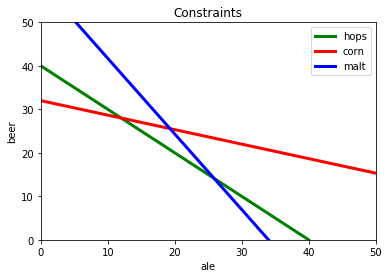

In [483]:
plt.plot([0,40],[40,0],'g-', linewidth=3, label='hops')
plt.plot([0,50],[32,15.333], 'r-', linewidth=3,label ='corn' )
plt.plot([5.24,34],[50,0], 'b-', linewidth=3, label='malt')
plt.xlabel('ale')
plt.ylabel('beer')
plt.title('Constraints')
plt.axis([0,50,0,50])
plt.legend()
plt.show()

Now let's plot the feasible region along with iso-profit lines.

In [515]:
cpts = np.array([[0,0],[0,32],[12,28],[26,14],[34,0],[0,0] ])
pts = lambda p: [[0,p/13.],[p/23.,0]]
p1 = pts(442)
p2 = pts(660)
p3 = pts(800)
p4 = pts(900)

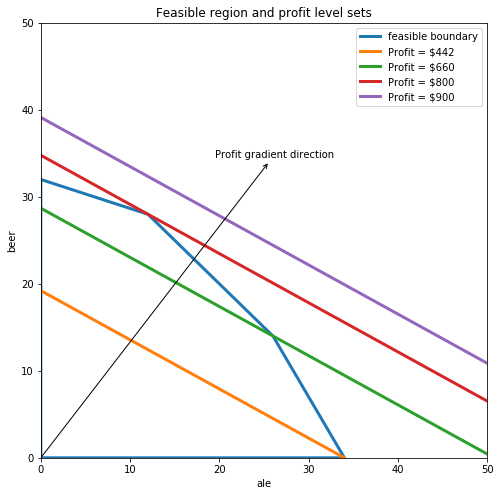

In [550]:
_=plt.figure(figsize=(8,8))
plt.plot(cpts.T[0],cpts.T[1], linewidth=3, label="feasible boundary")
plt.plot(p1[0],p1[1], linewidth=3, label="Profit = $442")
plt.plot(p2[0],p2[1], linewidth=3, label="Profit = $660")
plt.plot(p3[0],p3[1], linewidth=3, label="Profit = $800")
plt.plot(p4[0],p4[1], linewidth=3, label="Profit = $900")
#plt.plot([0, 1.5*13],[0,1.5*23], linewidth=3, label="Profit gradient")
plt.xlabel('ale')
plt.ylabel('beer')
plt.title('Feasible region and profit level sets')
plt.axis([0,50,0,50])
#plt.arrow(0,0,1.5*13, 1.5*23, head_width=1, head_length=2, fc='k', ec='k')
plt.annotate("Profit gradient direction", xy=(0,0), 
             xytext=(1.5*13,1.5*23), 
             arrowprops=dict(arrowstyle="<-"))
plt.legend()
plt.show()

Since the objective function is linear, the level sets are parallel lines normal to the profit (objective function) gradient direction.

This sort of picture motivates a geometric conclusion: For any linear objective function, an optimal solution occurs at an __extreme point__ (a vertex of the polygon bounding the feasible region).

What if the the objective gradient is normal to an edge bounding the feasible region? Then the entire edge consists of optimal solutions so an optimal solution does occur at an extreme point (actually 2 of them...).

So we can find an optimal solution by only testing the extreme points.

Even better, the linear constraints create a feasible region that is __convex__: the line connecting any 2 feasible points consists entirely of feasible points.

Convince yourself that the convexity of the feasible region ensures that an extreme point which is locally optimal (compared with neighboring vertices) must actually be the globally optimal solution.
(Think about how you would need to change the constraint polygon to create a local optimum that was not a global optimum.)

Together there solutions form the basis of a solution plan: Find a solution at an extreme point (constraint vertex) and keep moving to neighboring vertices that improve the objective function value. When no neighboring vertex offers an improved value, stop because that local optimum is actually the global optimum solution.

The next section looks at the details of implementing this solution method.

## Section 5.4 - Simplex Method

Start by introducing slack variables (and movingthe objective function definition to the bottom) to write the system in standard form (with only equality constaints):

|   | ale |   |beer   |   |   |   |   |   |   |
|---|---|---|---|---|---| ---|---|---|---|
| maximize  | Z |    |   |   |   |   |   |   |   |
| subject to  | 5A  | + | 15B | +$S_c$ | | | |=480 |  corn |
|  | 4A | + | 4B |  | +$S_h$ |  | |=160 |  hops |
|  | 35A | + | 20B |  |  | +$S_m$|  |=1190 |  malt |
|   | 13A | + | 23B |   |   |  | -Z |=0 |  profit |
|  |  |  | |   |  |  | A,B,$S_c, S_h,S_m$    | $\geq 0$  |   |


We now have a linear algebra problem with $m+1=4$ equations in the 6 variables $A,B,S_c,S_h,S_m,Z$.

As usual, we don't want to have to rewrite variable names all the time, so let's construct the coefficient matrix which in this context is called the __simplex tableau__:

\begin{bmatrix}
5 & 15 & 1 & 0 & 0 & 480 \\
4 & 4 & 0 & 1 & 0 & 160 \\
35 & 20 & 0 & 0 & 1 & 1190 \\
13 & 23 & 0 & 0 & 0 & 0
\end{bmatrix}

Note that this is a particular instance of the following block  matrix (with subscripts indicating array shape):

\begin{bmatrix}
A_{m \times n} & I_{m \times m} & b_{m \times 1} \\
c_{1 \times n}^T & 0_{m \times 1} & 0_{1 \times 1} 
\end{bmatrix}

where $A$ is the $m \times n$ matrix of coefficients from the constraint equations, $I$ is the $m \times m$ identity matrix, $b$ is the $m \times 1$ vector of constraint values, and $c$ is the $n \times 1$ coefficient vector from the objective function (also $c = \nabla f$). (Here $n$ is the total number of variables in the standard form, so it is the toal number of control and slack variables.)

>__Note__: The notation in the text corresponds to ordering the vector of variables with the slack variables before the control variables.

The plan to compute the solution involves row reductions (just as we did in Ch. 2 - Linear Systems) and no other row contains a Z, so it is common not to bother explicitly including the Z coefficient.

Having assembled the tableau, this is a good time to introduce the idea of basic variables. 

A __basic variable__ is any variable that appears only with coefficient 1 in tableau.

These variables are "basic" in the sense that their coefficient subarray provides a basis for $m$-dimensional space. At this point, the basic variables are the slack variables $S_c,S_h,S_m$ and their coefficient submatrix (the $m \times m$ identity matrix) provides a basis for 3-space.

At this point, we can already obtain a __basic feasible solution (BFS)__:

- Set $n-m$ variables to 0

- Solve m equations for remaining $m$ unknowns.

- If unique and feasible $\implies$ BFS.

- BFS $\iff$ extreme point



We can already carry out these steps (but perhaps not in the most interesting way) to get:

__Initial basic feasible solution:__
- Set the the non-basis (control) variables to zero: A=B=0 (and Z=0)
- Solve for the slack variables: $S_c = 480, S_h=160, S_m=1190$
- Extreme point on simplex (at the origin) with zero profit

Now "pivot" to an adjacent vertex by a row operation that movesa different variable into the basis. Here let's choose to move B into the basis, so divide the top equation by 15 and do row operations to zero out the other coefficient in second column. The updated tableau is:

\begin{bmatrix}
\frac{1}{3} & 1 & \frac{1}{15} & 0 & 0 & 32 \\
\frac{8}{3} & 0 & -\frac{4}{15} & 1 & 0 & 32 \\
\frac{85}{3} & 0 & -\frac{4}{3} & 0 & 1 & 550 \\
\frac{16}{3} & 0 & -\frac{23}{15} & 0 & 0 & -736
\end{bmatrix}

We moved B into the basis by moving another variable out. Which one?

And we get a new basic feasible solution (BFS):

A=$S_c=0$, B=32, $S_h=32, S_m=550$. The updated profit is improved to Z=$736$ (from the previous Z=$0$).

Before we go on, why did we choose to"pivot" on B (i.e. introduce B into the basis)?

Objective coefficient was positive (each unit of B improves objective function by $23$). We could also have pivoted on A and cancel out the rest of the left column, but a unit of A only produces $13...

Why pivot on the first equation?

- Preserves feasibility by ensuring RHS $\geq 0$

- Minimum ratio rule: min{480/15, 160/4, 1190/20} = min{32, 40, 59.5} so move $S_c$ out of basis first.

Now we move on and pivot to an adjacent extreme point by moving A into the basis and pivoting onthe second row.

In other words, divide the second row by $\frac{8}{3}$ and do row operations to cancel out the remaining coefficients in the left column to get the following updated tableau:

\begin{bmatrix}
0 & 1 & \frac{1}{10} & \frac{1}{8} & 0 & 28 \\
1 & 0 & -\frac{1}{10} & \frac{3}{8} & 0 & 12 \\
0 & 0 & -\frac{25}{6} & -\frac{85}{8} & 1 & 110 \\
0 & 0 & -1 & -2 & 0 & -800
\end{bmatrix}

With the basis (A,B,$S_m$}, we obtain the following updated basic feasible solution (BSF): $S_c=S_h=0$, A=12, B=28, $S_m=110$ that produces a profit of $800.

Should we keep going? We could move on and find the other adjacent vertex produces a lower profit, and then conclude that our local optimum must be the global optimum, so we can stop.

However, we can already decide to stop because all the coefficients in the bottom equation (describing the objective function) are negative. Pivoting to introduce $S_c$ or $S_h$ into the basis would introduce a non-zero value for one of them. In fact, it wouldhave to be positive. But the last row gives the following formula for the profit:

$$Z=800-S_c-2 S_h$$

so non-zero values for the non-basic variables can only decreaseteh profit from here, so Z=$800 is the optimal value.

## Section 5.5 - Genetic Algorithms

Read on your own.

## Lagrange multiplier

What if your objective function nad/or constraints are nonlinear?

The usual approach involves introduction of __Lagrange multipliers__.

Here we consider constrained optimization with a nonlinear objective function and nonlinear equality constraints:

\begin{equation}
\begin{split}
\text{minimize } \qquad &f(x_0,x_1,\ldots,x_{n-1})  \\
\text{subject to } \qquad &g_0(x_0,x_1,\ldots,x_{n-1})=0 \\
 \qquad &g_1(x_0,x_1,\ldots,x_{n-1})=0 \\
 \vdots \\
  \qquad &g_{m-1}(x_0,x_1,\ldots,x_{n-1})=0 
\end{split}
\end{equation}

The __Lagrange multiplier method__ converts the minimization problem to a multi-dimensional root-finding problem as follows:

- For each constraint $g_j=0$, introduce a multiplier $\lambda_j$ so the full set of $n+m$ coordinates becomes:
$$x_0,x_1,\ldots,x_{n-1}, \lambda_0,\lambda_1, \ldots, \lambda_{m-1}$$

- Form the Lagrangian: $$L = f +\sum_{j=0}^{m-1} \lambda_j g_j$$

- Apply the first order optimality conditions:

\begin{equation}
\begin{split}
\frac{\partial L}{\partial x_0} = 0 \\
\frac{\partial L}{\partial x_1} = 0 \\
\vdots \\
\frac{\partial L}{\partial x_{n-1}} = 0 \\
\frac{\partial L}{\partial \lambda_0} = 0 \\
\frac{\partial L}{\partial \lambda_1} = 0 \\
\vdots \\
\frac{\partial L}{\partial \lambda_{m-1}} = 0 
\end{split}
\end{equation}

### Simple example

Optimize $$f(x_0,x_1) = x_0 + x_1)$$ subject to the constraint 
$$x_0^2+x_1^2-2=0$$

Here we need a single multiplier $\lambda$ and the Lagrangian is:

$$L(x_0,x_1,\lambda)=f+\lambda g = x_0+x_1+\lambda (x_0^2+x_1^2-2)$$

We apply the first order conditions (set the partial derivatives to zero to obtain:

\begin{equation}
\begin{split}
\frac{\partial L}{\partial x_0} &= 1+2 \lambda x_0 &= 0 \\
\frac{\partial L}{\partial x_1} &= 1+2 \lambda x_1 &= 0 \\
\frac{\partial L}{\partial \lambda} &= x_0^2+x_1^2-2 &= 0
\end{split}
\end{equation}

We end up having to solve a system of nonlinear equations (which can be challenging) but, inthis case, we can readily obtain the solutions:

- First 2 equations $\implies x_0 = x_1 = -\frac{1}{2 \lambda}$

- $3^{rd} \text{ equation } \implies x_0^2 = x_1^2 = 1$

- Solutions:
$$\lambda = -1/2, x_0 =  x_1 = 1$$
$$\lambda = 1/2, x_0 =  x_1 = -1$$

These are the critical points. By evaluating the function, we can see that the first solution is the maximum and the second is the minimum.

You can also tell this from the second order condition involving the Hessians:

\begin{equation}
H(f+ \lambda g) = H(f) + \lambda H(g) = 
\begin{bmatrix} 
0 & 0 \\
0 & 0 \\
\end{bmatrix}
+\lambda
\begin{bmatrix} 
2 & 0 \\
0 & 2 \\
\end{bmatrix}
=
\begin{bmatrix} 
2 \lambda & 0 \\
0 & 2 \lambda \\
\end{bmatrix}
\end{equation}

Nowthe question is whether this matrix is positive/negative definite (indicating a minimum/maximum) for an arbitrary displacement $d = (d_0,d_1)$ that satisfies the constraint at the critical point. 

Since we are now focused on behavior at the critical point, we can linearize the constraint:

$$g(x_0+d_0,x_1+d_1)=g(x_0,x_1) + \nabla g(x_0,x_1)^T d + \ldots = 0$$

$$ g(x+d)=0 \rightarrow \nabla g(x_0,x_1)^T d = 0$$

For the first solution:

\begin{equation}
\nabla f^t d = 
\begin{bmatrix} 
2 & 2 \\
\end{bmatrix}
\begin{bmatrix} 
d_0 \\
d_1 \\
\end{bmatrix}
=2 d_0+2 d_1 = \alpha
\begin{bmatrix} 
1 \\
-1 \\
\end{bmatrix}
\end{equation}

The quadratic form becomes:

\begin{equation}
d^T H(L) d = \alpha^2
\begin{bmatrix} 
1 & -1 \\
\end{bmatrix}
\begin{bmatrix} 
-1 & 0  \\
0 & -1 \\
\end{bmatrix}
\begin{bmatrix} 
1  \\
-1 \\
\end{bmatrix}
= -2 \alpha^2 \leq 0
\end{equation}

The quadratic form describing the function near the critical point is negative definite, and the first solution is confirmed as the maximum.

At the second critical point, things go pretty much the same, but $ \lambda = 1/2$ and the Hession has $1$ on the diagonal instead of $-1$:

\begin{equation}
d^T H(L) d = \alpha^2
\begin{bmatrix} 
1 & -1 \\
\end{bmatrix}
\begin{bmatrix} 
1 & 0  \\
0 & 1 \\
\end{bmatrix}
\begin{bmatrix} 
1  \\
-1 \\
\end{bmatrix}
= 2 \alpha^2 \leq 0
\end{equation}

The quadratic form describing the function near the critical point is positive definite, and the second solution is confirmed as the maximum.

### A more interesting example:

Find $r$ and $h$ to minimize $$f=-\pi r^2 h$$

subject to the constraint

$$g = 2 \pi r^2 +2 \pi r h - A = 0$$

Find the shape of a cylinder that maximizes the volume for a given surface area.

$$L f + \lambda g = -\pi r^2 h + \lambda  \,(2 \pi r^2 + 2 \pi r h -A)$$

\begin{equation}
\begin{split}
\frac{\partial L}{\partial r} &= -2 \pi r h + 4 \pi r \lambda + 2 \pi h  \lambda &= 0 \\
\frac{\partial L}{\partial h} &= -\pi r^2 + 2 \pi r \lambda &= 0 \\
\frac{\partial L}{\partial \lambda} &= 2 \pi r^2 +2 \pi r h -A &= 0
\end{split}
\rightarrow \lambda = \frac{\pi r^2}{2 \pi r} = r/2
\end{equation}

Plugging in gives:

$$2r = h = \sqrt{\frac{2A}{3 \pi}}$$

Do you think this is a max or a min?